Now we can make the spectroscopic light curves given all spectra are aligned and the wavelength solution has been calculated.

In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import reduction_utils.wavelength_binning as wb
import reduction_utils.wavelength_calibration as wc
import matplotlib.pyplot as plt
import pickle

First of all, I check what airmasses the data were taken at. If I have plenty of out of transit data, I will ignore data taken at airmass > 2. If not, I keep all data regardless of airmass.

I also check the sky background. If observations were taken at the end of the night, we sometimes observe into morning twilight and the sky background increases quickly and suddenly, which can introduce unwanted noise in the light curves.

Load in the airmass array:

In [3]:
parent_direc = '/Users/james/ACAMdata/hat44/20180326/reduction12/no_flat/'

am = pickle.load(open(parent_direc+'pickled_objects/airmass.pickle','rb'))

print(am[0],min(am),am[-1])

1.746462 1.052405 1.310073


OK, so this case I don't need to perform an airmass cut. 

Also, now load in the input data:

In [4]:
wvl_solution_1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/wavelength_solution.pickle','rb'))

f1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','rb'))
f2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','rb'))

e1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_error_resampled.pickle','rb'))
e2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_error_resampled.pickle','rb'))

mjd = pickle.load(open(parent_direc+'pickled_objects/mjd_time.pickle','rb'))

exp_times = pickle.load(open(parent_direc+'pickled_objects/exposure_times.pickle','rb'))

sky1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky1_resampled.pickle','rb'))
sky2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky2_resampled.pickle','rb'))

print(sky1.shape)

xpos1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos1_resampled.pickle','rb'))
xpos2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos2_resampled.pickle','rb'))

nframes = len(f1)

(88, 1670)


First, we need to rescale the sky background to account for the differing exposure times.

We also only want to deal with a single sky array, so we take the mean of the sky arrays recorded at the locations of the 2 stars.

In [5]:
sky1 = np.array([i/j for i,j in zip(sky1,exp_times)])
sky2 = np.array([i/j for i,j in zip(sky2,exp_times)])

sky1_norm = (sky1-sky1.mean())/sky1.std()
sky2_norm = (sky2-sky2.mean())/sky2.std()

sky = np.mean((sky1_norm,sky2_norm),axis=0)

Now I also standardise (subtract the mean and divide by the standard deviation) the x positions, and again combine into a single array for both stars. The standardisation is neccessary to help with the fitting process later on.

In [6]:
xpos1_norm = (xpos1-xpos1.mean())/xpos1.std()
xpos2_norm = (xpos2-xpos2.mean())/xpos2.std()

xpos = np.mean((xpos1_norm,xpos2_norm),axis=0)

Now plot the white light curve to determine the positions of the contact points in frame number, and to check the noise in the light curve and whether I should cut any data out (due e.g. to clouds).

<IPython.core.display.Javascript object>


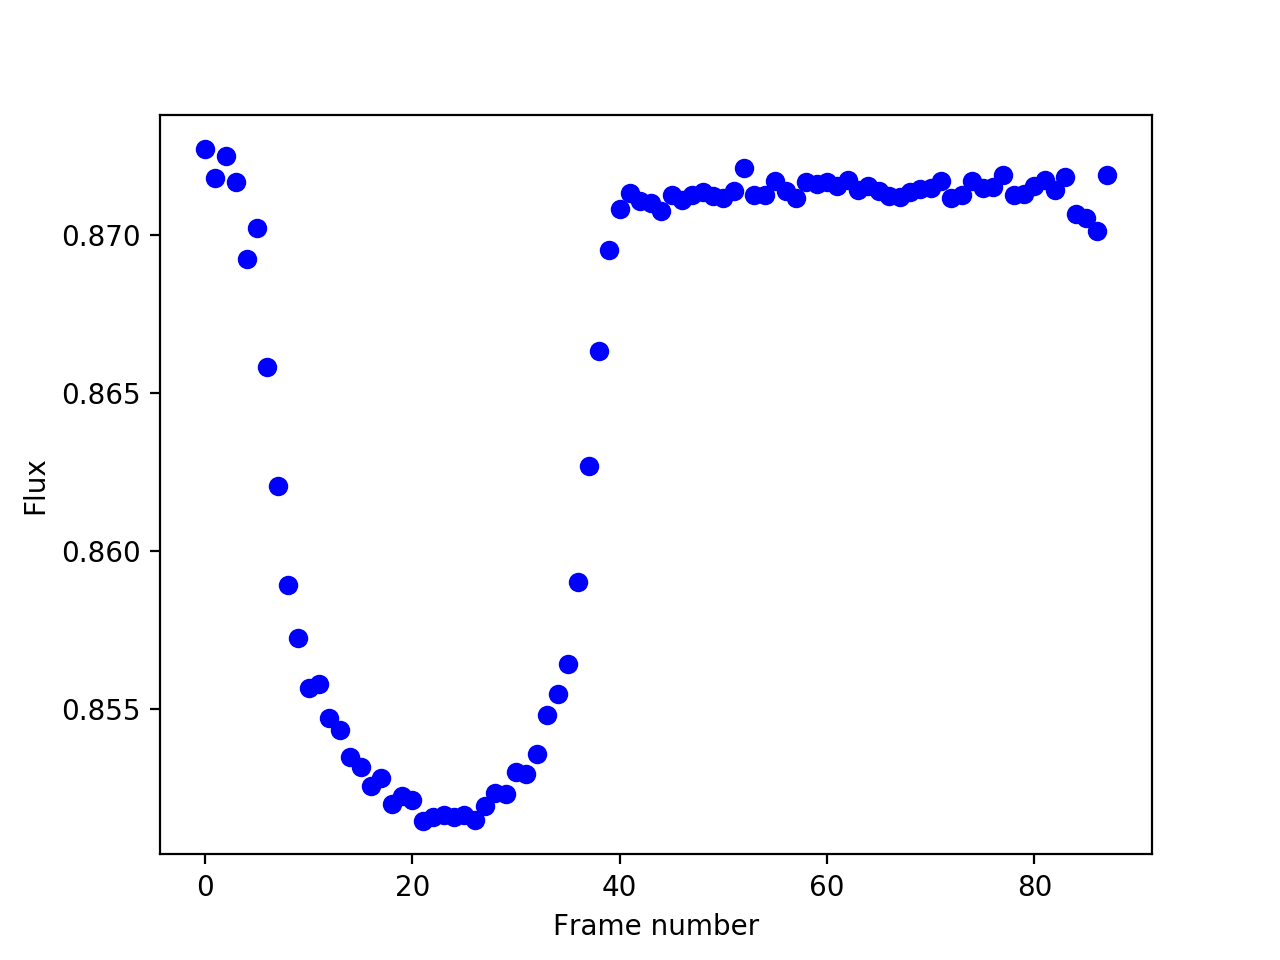

In [7]:
plt.figure()
plt.plot(f1.sum(axis=1)/f2.sum(axis=1),'bo')
plt.ylabel('Flux')
plt.xlabel('Frame number')
plt.show()

Ok, so there is some noise in the final 4 points and I know from the ancillary_plots.pdf figures that the sky is brightening for final 4 frames so I'll remove these.

Also plot the sky flux to check for clouds.

<IPython.core.display.Javascript object>


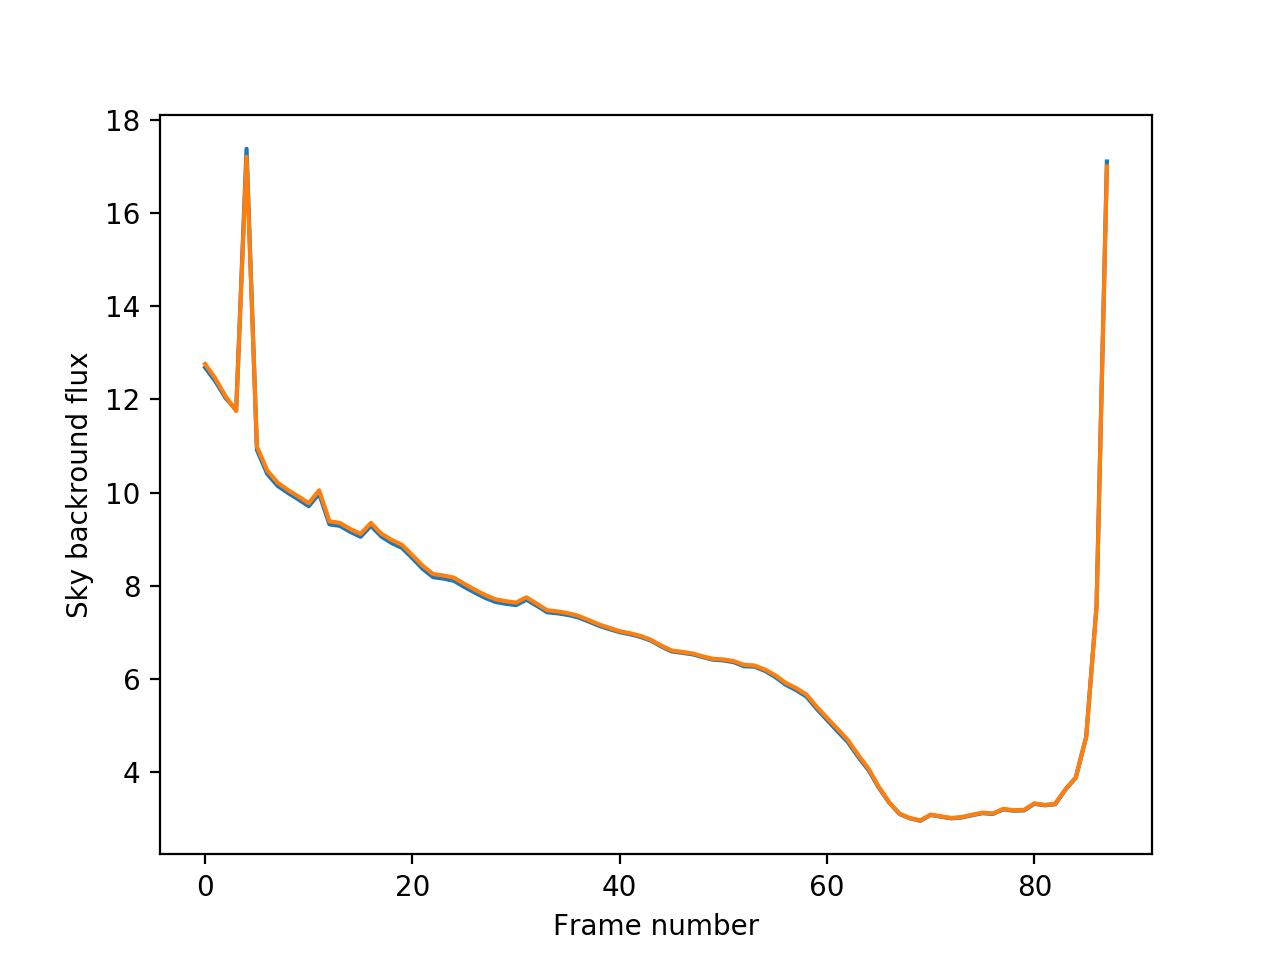

In [8]:
plt.figure()
plt.plot(sky1.mean(axis=1))
plt.plot(sky2.mean(axis=1))
plt.ylabel('Sky backround flux')
plt.xlabel('Frame number')
plt.show()

In addition to the steep increase in the sky background at the end of the night, there is also a sharp increase in frame 5 which is likely due to clouds and can be removed by hand.

So we'll remove frame 5, and all frames > 84 from the arrays, done by hand as:

In [9]:
f1 = np.vstack((f1[:4],f1[5:84]))
f2 = np.vstack((f2[:4],f2[5:84]))

e1 = np.vstack((e1[:4],e1[5:84]))
e2 = np.vstack((e2[:4],e2[5:84]))

mjd = np.hstack((mjd[:4],mjd[5:84]))

exp_times = np.hstack((exp_times[:4],exp_times[5:84]))

sky1 = np.vstack((sky1[:4],sky1[5:84]))
sky2 = np.vstack((sky2[:4],sky2[5:84]))

xpos1 = np.vstack((xpos1[:4],xpos1[5:84]))
xpos2 = np.vstack((xpos2[:4],xpos2[5:84]))

nframes = len(f1)

And the contact points from the white light curve:

In [10]:
contact1 = 3
contact4 = 40

Now we can plot the spectra to begin defining where the bins should be located.

<IPython.core.display.Javascript object>


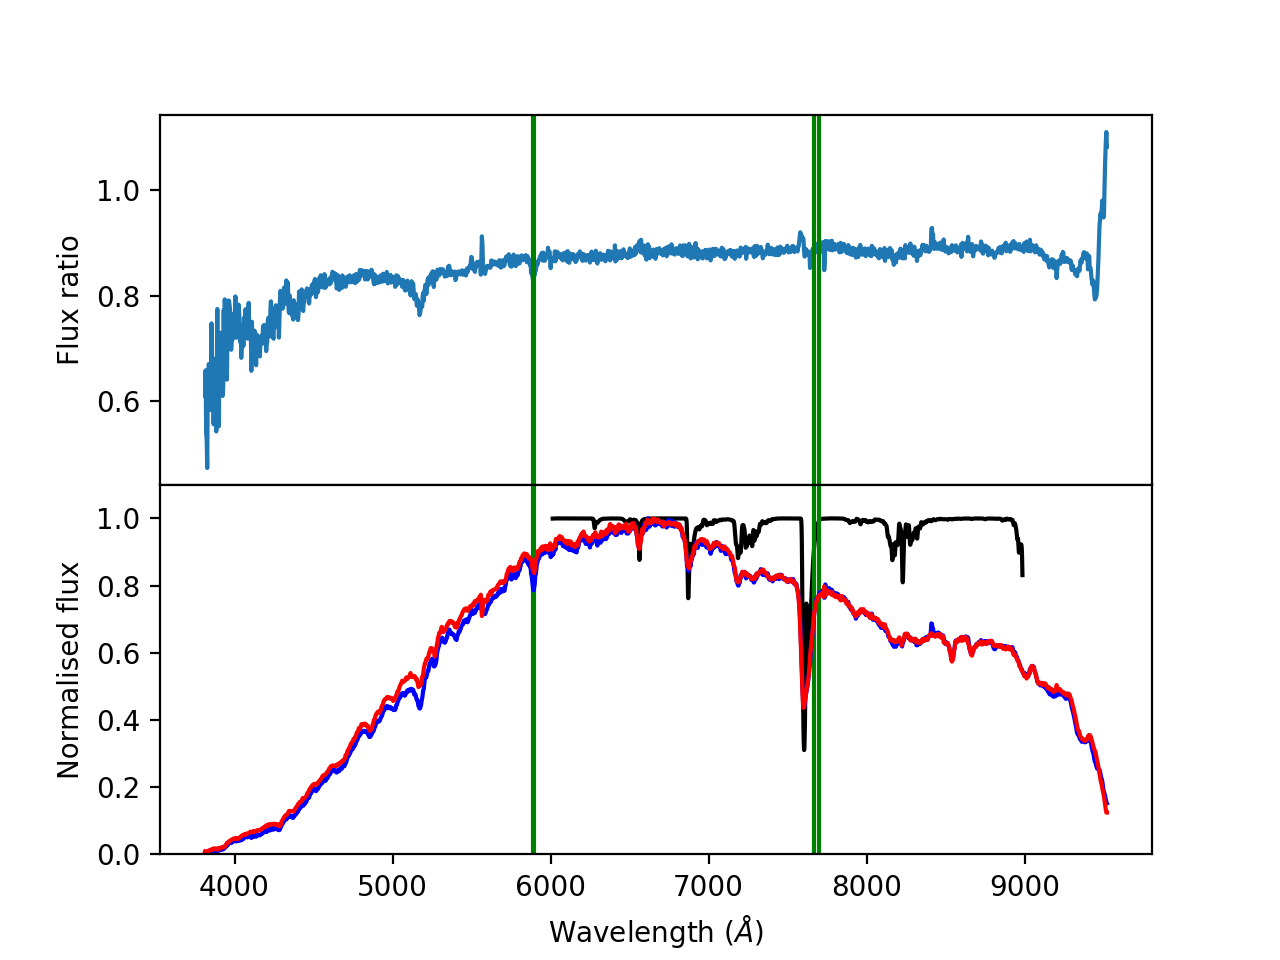

In [11]:

wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,telluric=True)


### Spectroscopic bins

Now we begin the iterative process of defining bin edges. We want to go as narrow as possible (100-250A) and cover as much wavelength range (4000-9250A) while avoiding bin edges falling on strong stellar/telluric absorption lines and making sure the noise in the resulting light curves is not too severe.

Using bins I made earlier (with wider bins for the blue and red edges)...

In [12]:

bin_edges = [4500,4910,5230,5480,5730,5980,6230,6480,6730,6980,7120,7370,\
             7530,7870,8120,8370,8620,8870,9200]

nbins = len(bin_edges) - 1

bin_centres = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(nbins)])
bin_widths = np.array([(bin_edges[i+1]-bin_edges[i]) for i in range(nbins)])

print(bin_centres)

print(bin_widths)

[4705. 5070. 5355. 5605. 5855. 6105. 6355. 6605. 6855. 7050. 7245. 7450.
 7700. 7995. 8245. 8495. 8745. 9035.]
[410 320 250 250 250 250 250 250 250 140 250 160 340 250 250 250 250 330]


<IPython.core.display.Javascript object>


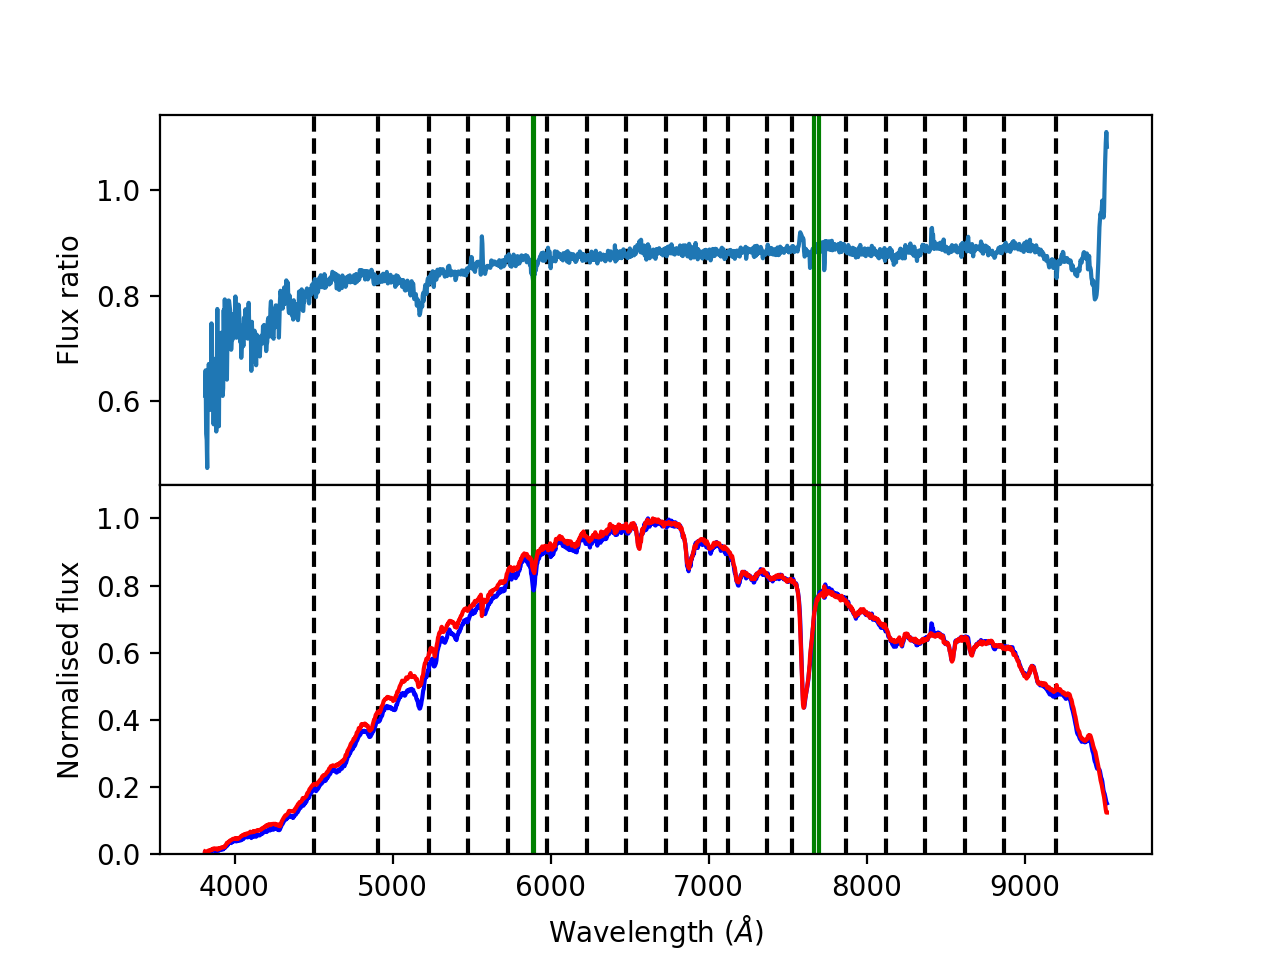

In [13]:
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,\
                bin_edges=bin_edges,telluric=False,ratio=True)

So this is perhaps overly zealous in removing the red and blue edges.

Now make the spectroscopic light curves by portioning the spectra into the above bins and making light curves for each bin. We also need to portion out the ancillary data (sky flux and x position) into the same bins for use in the fitting process later on.

In [14]:
help(wb.wvl_bin_data)

Help on function wvl_bin_data in module reduction_utils.wavelength_binning:

wvl_bin_data(flux1, err1, flux2, err2, wvl_solution, bins, xpos, sky, weighted=False, n_tukey_points=0)
    A function to bin the spectra of the target and comparison to make spectroscopic light curves for each by summing the flux within the defined wavelength bins.
        The target's light curves are divided by the comparison's light curves to correct for telluric extinction.
    
    Inputs:
    flux1 - ndarray of spectra of the target
    err1 - ndarray of errors of the target
    flux2 - ndarray of spectra of the comparison
    err2 - ndarray of errors of the comparison
    wvl_solution - the wavelength solution which is used to bin the data. This is assuming that both the target and the comparison have been resampled onto the same x-axis.
                       My tests show that this provides much better light curves than using separate wavelength solutions
    bins - the list of bin edges of the light

In [15]:
bin_fluxes,bin_errors,bin_fluxes_target,bin_errors_target,bin_fluxes_comp,bin_errors_comp,\
bin_xpos,bin_sky,photon_noise_star1,photon_noise_star2 = \
wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,bin_edges,xpos=xpos,sky=sky,n_tukey_points=0,weighted=False)

Now normalise the light curves to the out of transit data and plot:

<IPython.core.display.Javascript object>


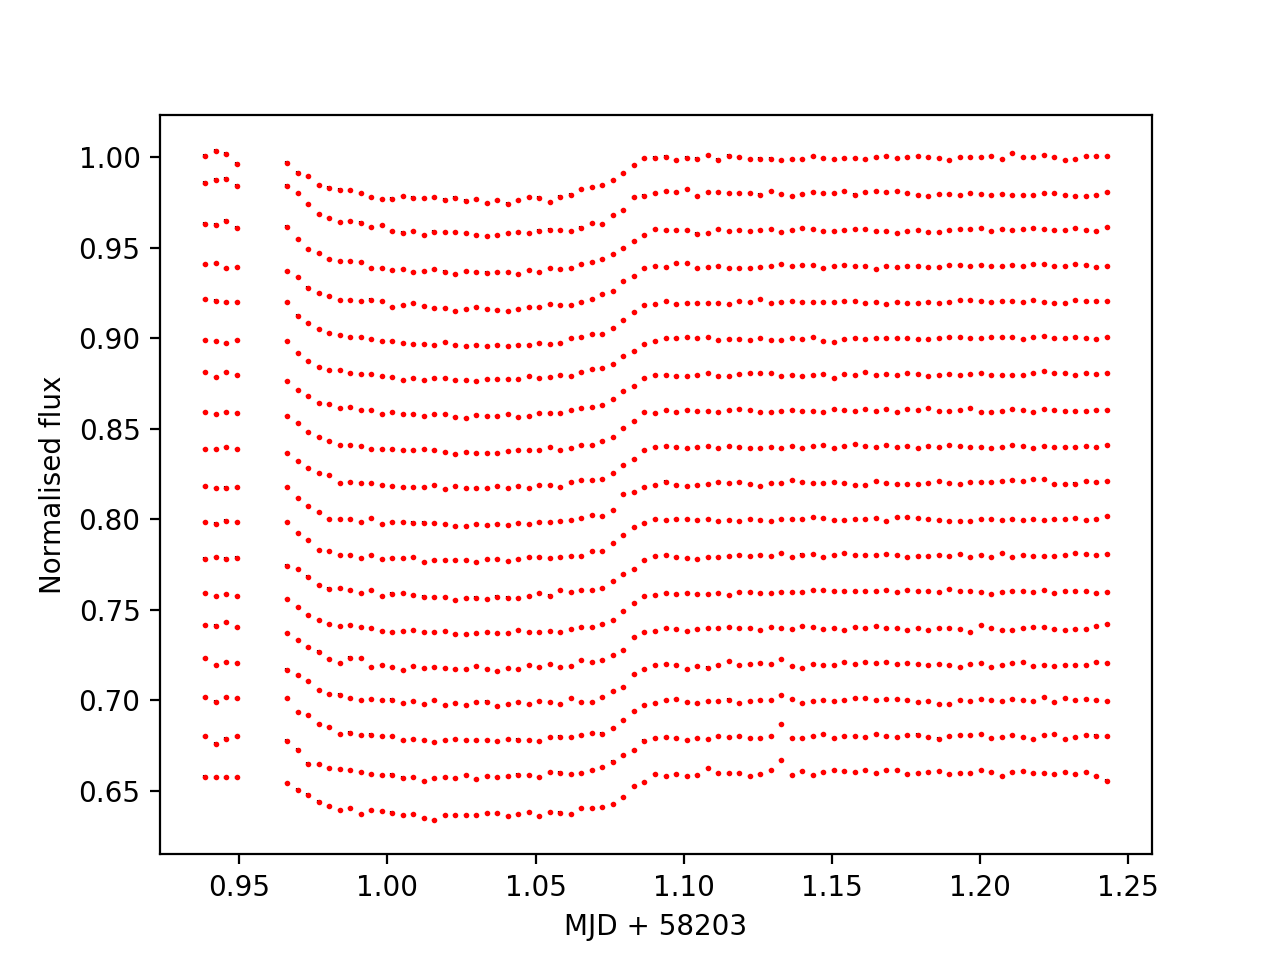

In [16]:
nf, ne = wb.normalise_flux(bin_fluxes,bin_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf,ne)

So these are our spectroscopic (wavelength-binned) light curves going from blue (top) to red (bottom). Ultimately what we are trying to determine is whether the depth of the transit varies between these light curves.

If we're happy, save the output:

In [17]:
# pickle.dump(nf,open('../pickled_objects/wvl_bins/fluxes.pickle','wb'))
# pickle.dump(ne,open('../pickled_objects/wvl_bins/errors.pickle','wb'))

# pickle.dump(bin_centres,open('../pickled_objects/wvl_bins/wvl_bin_centres.pickle','wb'))
# pickle.dump(bin_widths,open('../pickled_objects/wvl_bins/wvl_bin_full_widths.pickle','wb'))

# pickle.dump(bin_xpos,open('../pickled_objects/wvl_bins/xpos.pickle','wb'))
# pickle.dump(bin_sky,open('../pickled_objects/wvl_bins/sky.pickle','wb'))

# pickle.dump(photon_noise_star1,open('../pickled_objects/wvl_bins/photon_noise_star1.pickle','wb'))
# pickle.dump(photon_noise_star2,open('../pickled_objects/wvl_bins/photon_noise_star2.pickle','wb'))

### Sodium bins

We also want to make narrower bins centred on the sodium and potassium lines, which are expected to be strong absorption lines in the atmospheres of the planets we consider.

We do this in 2 ways, firstly by making a handful of narrow bins of uniform width centred on each feature and covering ~200A. And secondly by having a single bin centred on each feature and making a single light curve. We then incrementally increase this bin width by 10A, until the bin centred on the feature is ~100A wide. I call this 'incrementally increasing bins'.

First start off with 5 bins of 30A width centred on sodium:

<IPython.core.display.Javascript object>


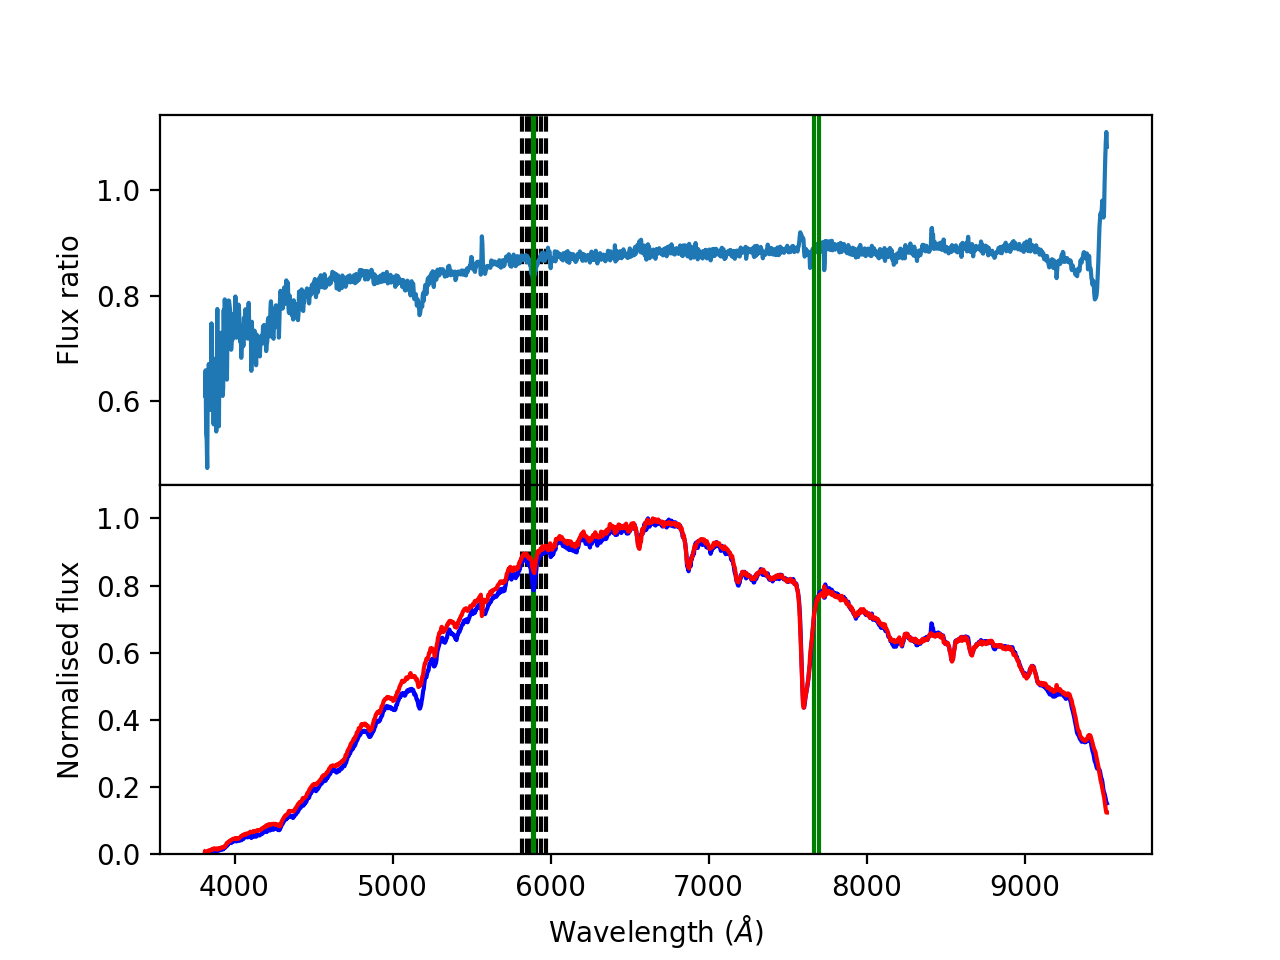

In [18]:
no_bins_na = 5
bin_width_na = 30
na_centre = wb.sodium_centre

# Now make the wavelength bins for sodium
na_bins = np.arange(na_centre-(bin_width_na/2)*no_bins_na,na_centre+(bin_width_na/2)*(no_bins_na+1),bin_width_na)
na_bins_centres = np.array([(na_bins[i+1]+na_bins[i])/2 for i in range(no_bins_na)])
na_bins_widths = np.array([(na_bins[i+1]-na_bins[i]) for i in range(no_bins_na)])

# And plot these to make sure everything looks OK
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,bin_edges=na_bins,alkali=True)




Ok, these look to be well centred on sodium, now make the light curves as before:

(I'm neglecting the flux of the target and comparison from the returned variables, hence defining them with the underscore)

<IPython.core.display.Javascript object>


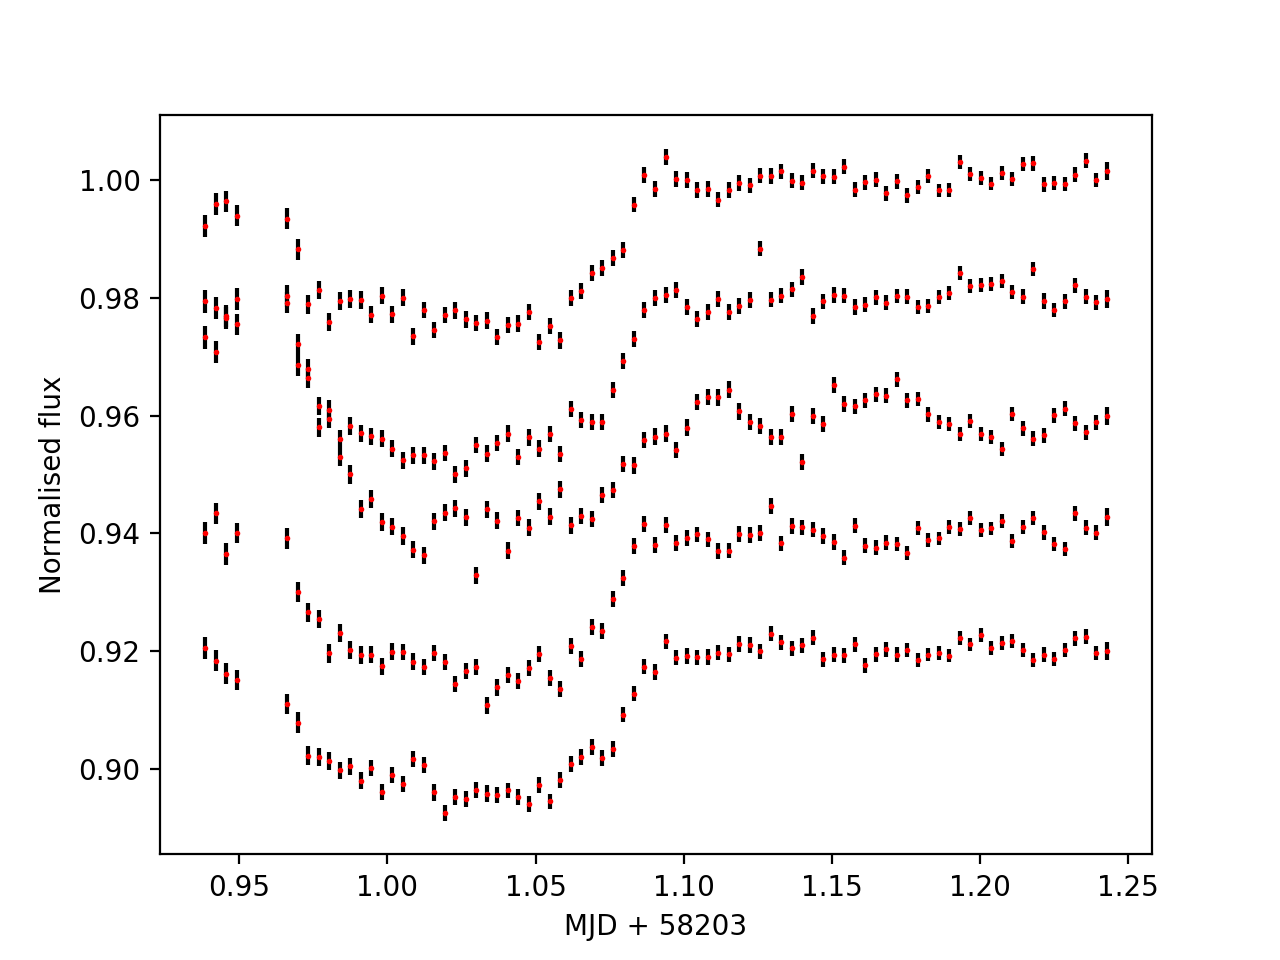

In [19]:
na_bins_fluxes,na_bins_errors,_,_,_,_,na_bins_xpos,na_bins_sky,_,_ = \
wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,na_bins,n_tukey_points=0,xpos=xpos,sky=sky,weighted=False)

nf_na, ne_na = wb.normalise_flux(na_bins_fluxes,na_bins_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf_na,ne_na)

These are noisier than the wider bins above but that's OK. Now save the output:

In [20]:
# pickle.dump(nf_na,open('../pickled_objects/Na/fluxes.pickle','wb'))
# pickle.dump(ne_na,open('../pickled_objects/Na/errors.pickle','wb'))

# pickle.dump(na_bins_xpos,open('../pickled_objects/Na/xpos.pickle','wb'))
# pickle.dump(na_bins_sky,open('../pickled_objects/Na/sky.pickle','wb'))

# pickle.dump(na_bins_centres,open('../pickled_objects/Na/bin_centres.pickle','wb'))
# pickle.dump(na_bins_widths,open('../pickled_objects/Na/bin_widths.pickle','wb'))

And make the 'incrementally increasing bins' (iib), starting from a width of 10A and increasing to 100A, in steps of 10A.

<IPython.core.display.Javascript object>


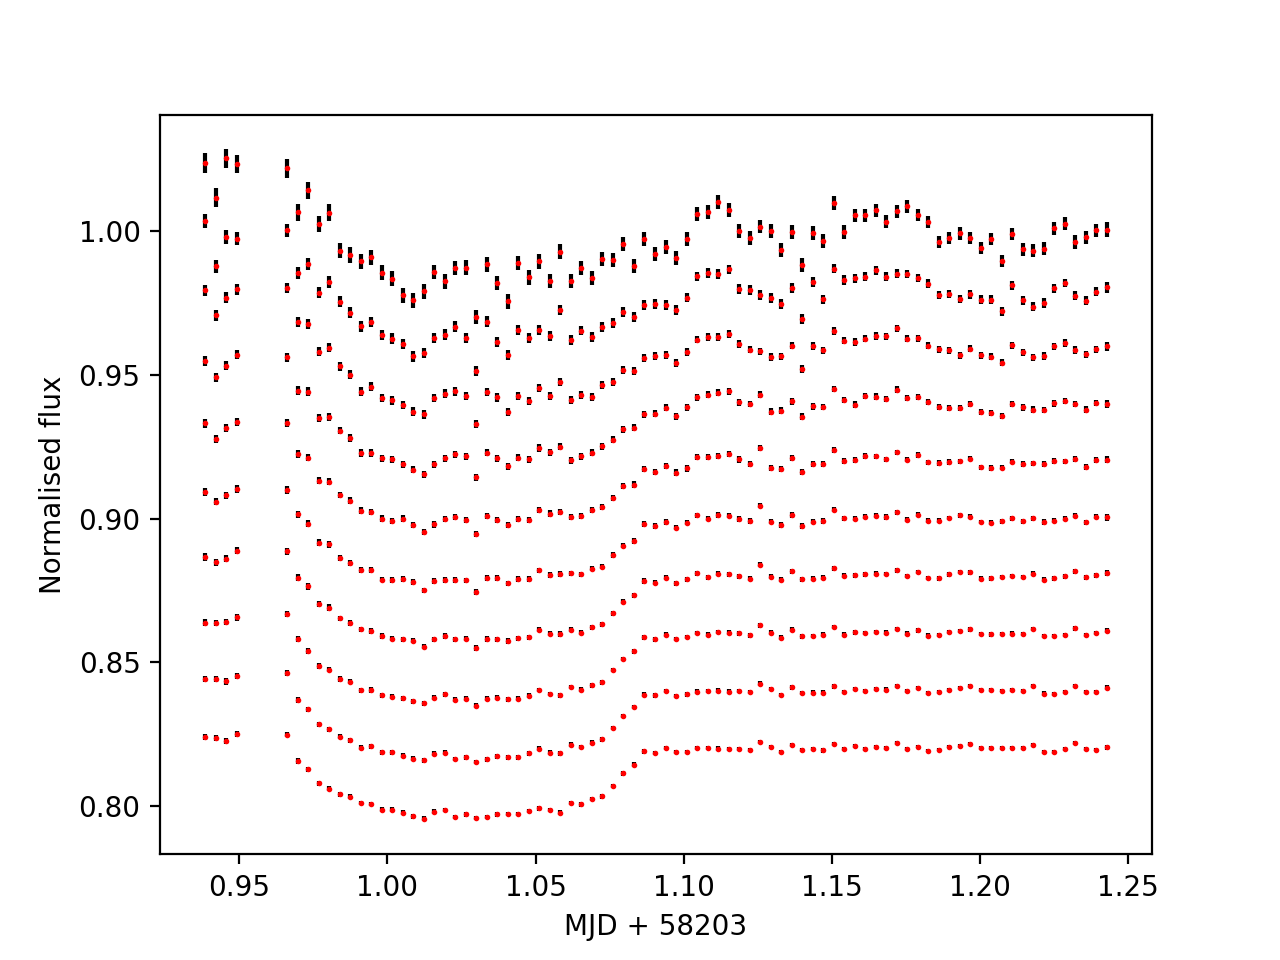

In [21]:
bin_widths_iib = np.arange(10,110,10)

iib_fluxes_Na = []
iib_errors_Na = []
iib_xpos_Na = []
iib_sky_Na = []
iib_centres_Na = []
iib_widths_Na = []

for i in bin_widths_iib:
    
    bin_left = na_centre - i/2
    bin_right = na_centre + i/2
    iib_centres_Na.append(na_centre)
    iib_widths_Na.append(i)
    
    curr_flux,curr_error,_,_,_,_,curr_xpos,curr_sky,_,_ = wb.wvl_bin_data(f1,e1,f2,e2, wvl_solution_1,np.array([bin_left,bin_right]),n_tukey_points=0,xpos=xpos,sky=sky,weighted=False)

    iib_fluxes_Na.append(curr_flux[0])
    iib_errors_Na.append(curr_error[0])
    iib_xpos_Na.append(curr_xpos[0])
    iib_sky_Na.append(curr_sky[0])
    
iib_fluxes_Na = np.array(iib_fluxes_Na)
iib_errors_Na = np.array(iib_errors_Na)
iib_centres_Na = np.array(iib_centres_Na)
iib_widths_Na = np.array(iib_widths_Na)
iib_xpos_Na = np.array(iib_xpos_Na)
iib_sky_Na = np.array(iib_sky_Na)
    
nf_na_iib, ne_na_iib = wb.normalise_flux(iib_fluxes_Na,iib_errors_Na,contact1,contact4)

wb.plot_all_bins(mjd,nf_na_iib, ne_na_iib)

And save:

In [22]:
# pickle.dump(nf_na_iib,open('../pickled_objects/Na/iib/fluxes.pickle','wb'))
# pickle.dump(ne_na_iib,open('../pickled_objects/Na/iib/errors.pickle','wb'))

# pickle.dump(iib_centres_Na,open('../pickled_objects/Na/iib/centres.pickle','wb'))
# pickle.dump(iib_widths_Na,open('../pickled_objects/Na/iib/widths.pickle','wb'))

# pickle.dump(iib_xpos_Na,open('../pickled_objects/Na/iib/xpos.pickle','wb'))
# pickle.dump(iib_sky_Na,open('../pickled_objects/Na/iib/sky.pickle','wb'))

### Potassium bins

Now do the same for the potassium doublet. The difference here, however, is that the doublet has a larger separation (30A) than sodium (5A). It is also right next to the big telluric O2-A band absorption line. Therefore, I choose to centre on the redder of the two potassium lines.

<IPython.core.display.Javascript object>


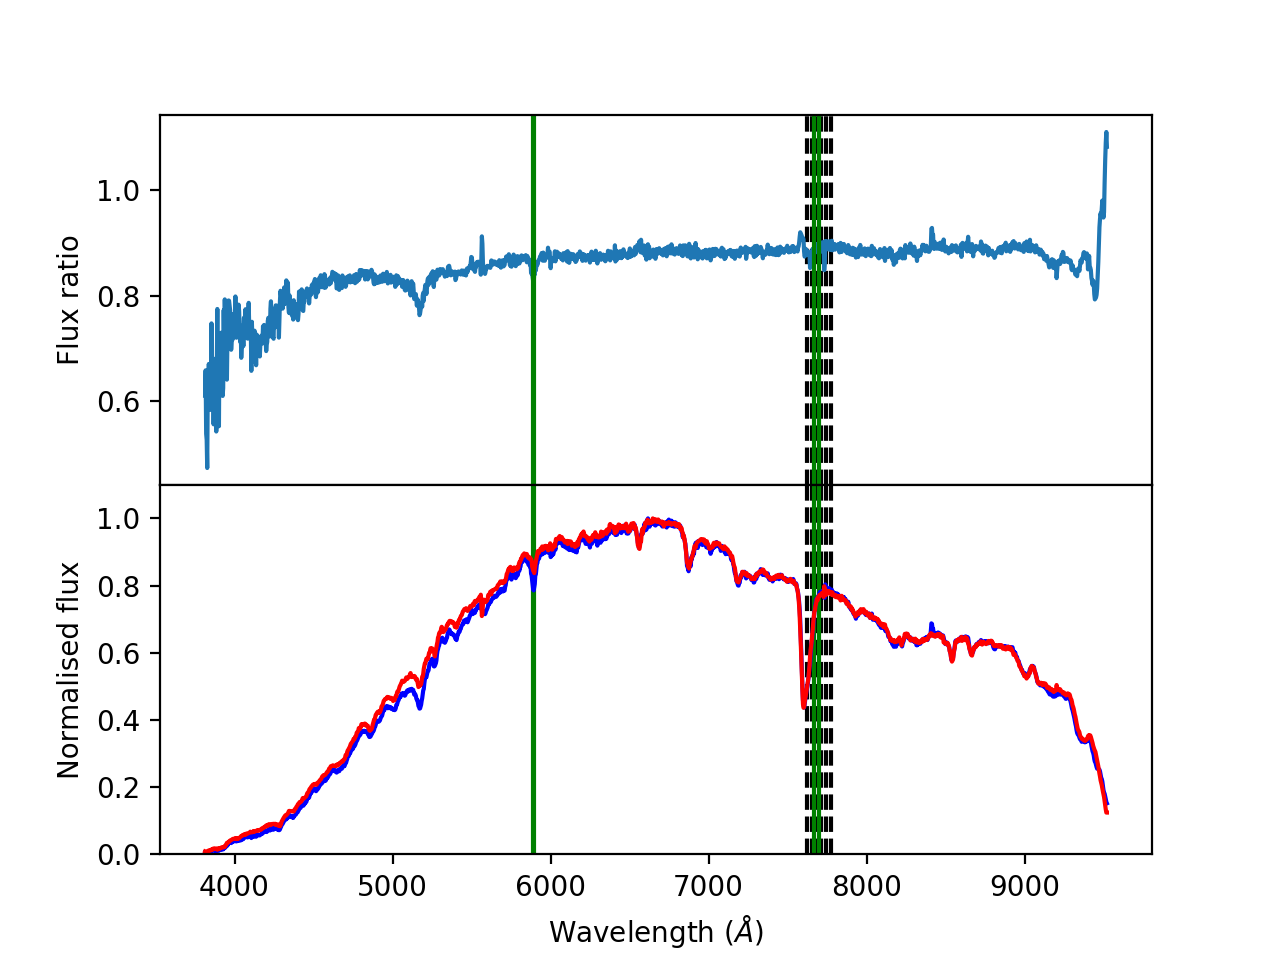

In [23]:
no_bins_K = 5
bin_width_K = 30

K_bins = np.arange(wb.potassium_d2-(bin_width_K/2)*no_bins_K,wb.potassium_d2+(bin_width_K/2)*(no_bins_K+1),bin_width_K)
K_bins_centres = np.array([(K_bins[i+1]+K_bins[i])/2 for i in range(no_bins_K)])
K_bins_widths = np.array([(K_bins[i+1]-K_bins[i]) for i in range(no_bins_K)])

wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,bin_edges=K_bins,alkali=True)


Again looks OK, but it's hard to tell as there's no stellar feature to guide the eye.

Now make the light curves.

<IPython.core.display.Javascript object>


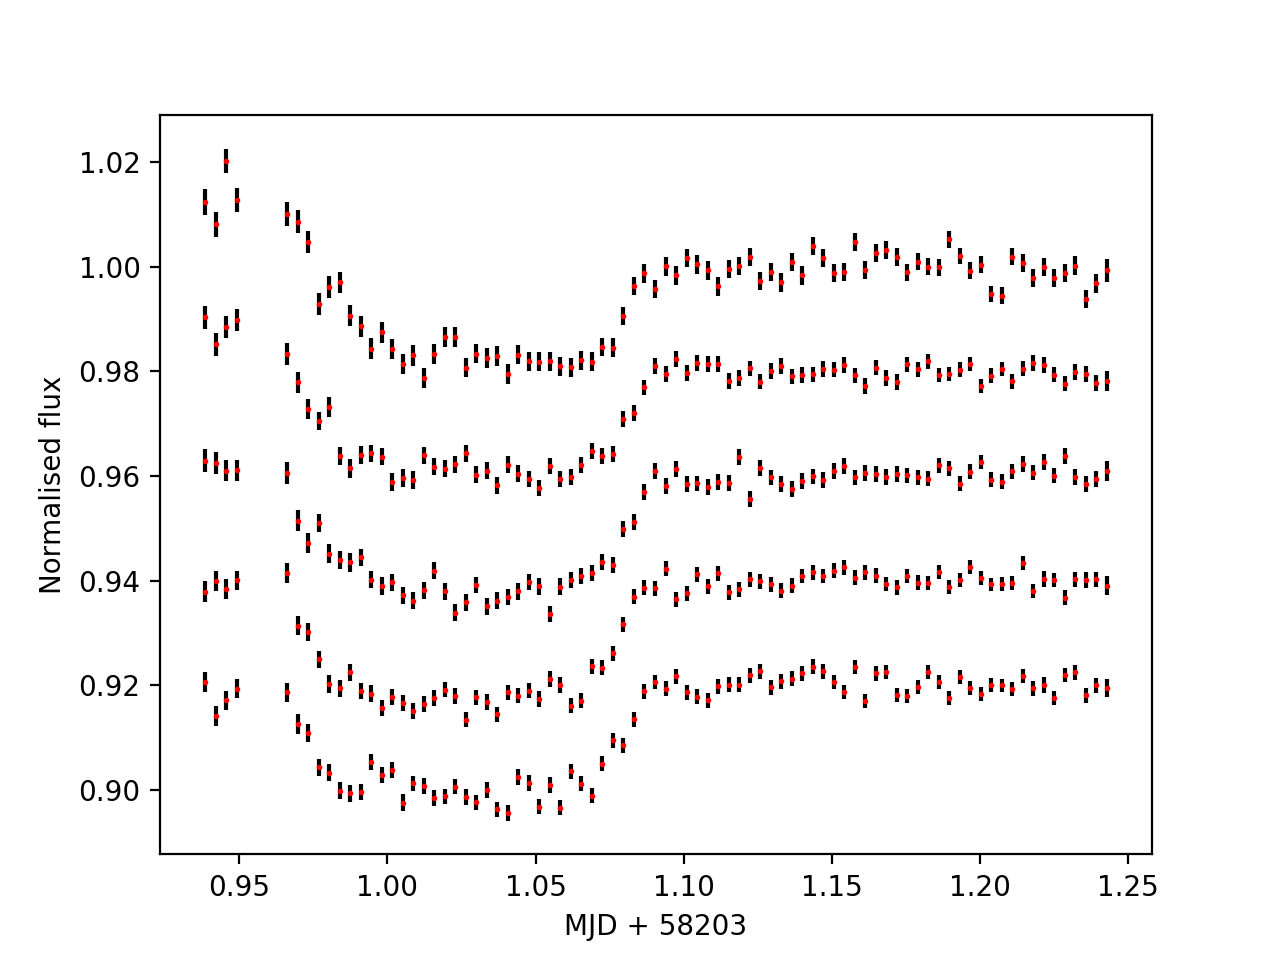

In [24]:
K_bins_fluxes,K_bins_errors,_,_,_,_,K_bins_xpos,K_bins_sky,_,_ = wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,\
                                                                            K_bins,n_tukey_points=0,\
                                                                                 xpos=xpos,sky=sky,weighted=False)

nf_K, ne_K = wb.normalise_flux(K_bins_fluxes,K_bins_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf_K, ne_K)

Light curves look pretty good. Now save:

In [25]:
# pickle.dump(nf_K,open('../pickled_objects/K/fluxes.pickle','wb'))
# pickle.dump(ne_K,open('../pickled_objects/K/errors.pickle','wb'))

# pickle.dump(K_bins_centres,open('../pickled_objects/K/centres.pickle','wb'))
# pickle.dump(K_bins_widths,open('../pickled_objects/K/widths.pickle','wb'))

# pickle.dump(K_bins_xpos,open('../pickled_objects/K/xpos.pickle','wb'))
# pickle.dump(K_bins_sky,open('../pickled_objects/K/sky.pickle','wb'))

For potassium iib, we centre the bin on the first line and step outwards to the right, to make sure we don't include too much of the telluric O2 line.

First find where the lines are in relation to the tellurics.

<IPython.core.display.Javascript object>


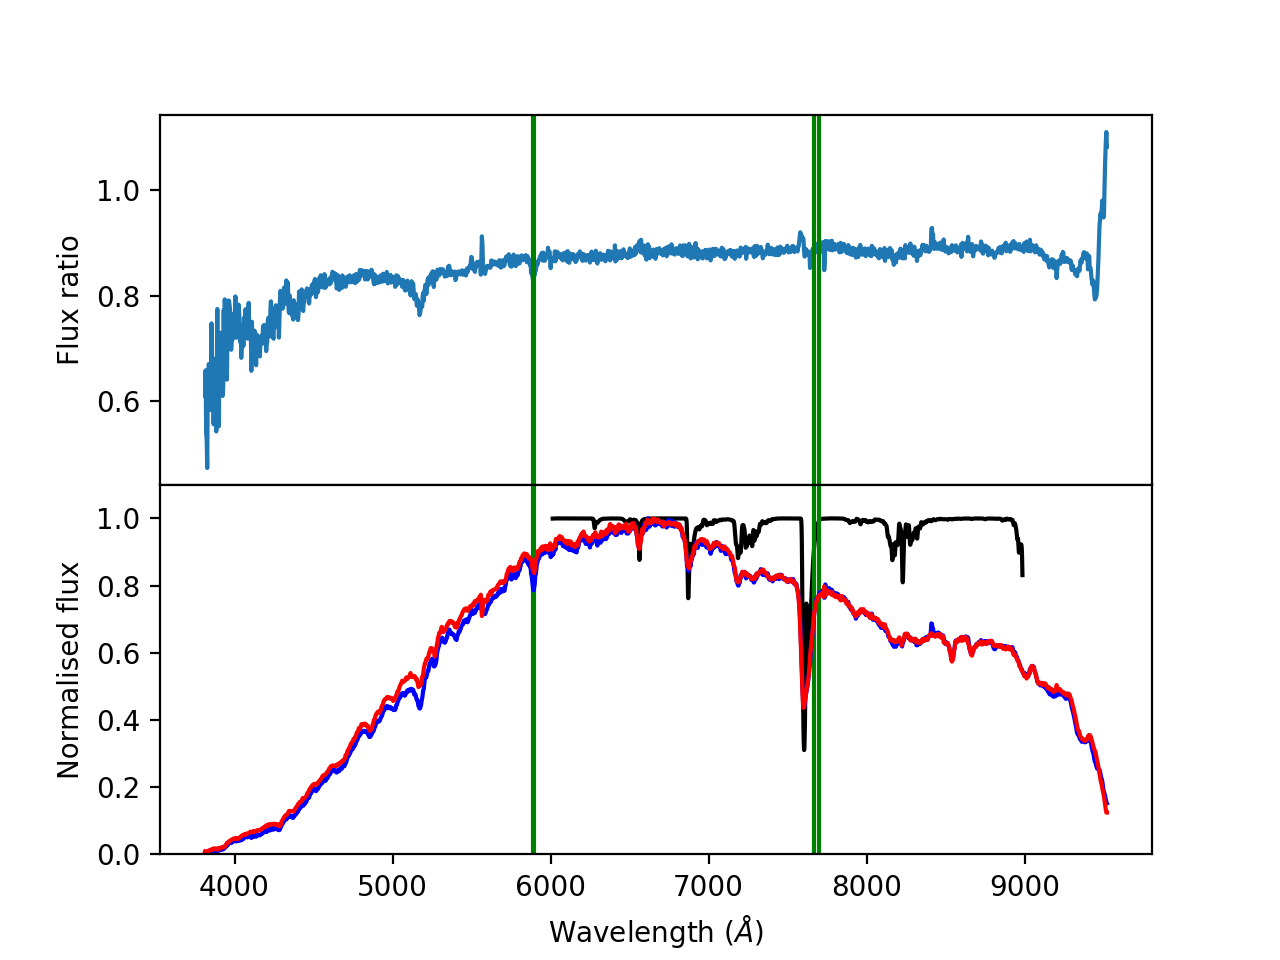

In [26]:
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,telluric=True)

OK, so K D1 occurs where telluric O2 is at approx 90% transmission. Make left hand edge where it reaches 70% transmission.

In [27]:
telluric_wvl,telluric_flux = np.loadtxt('../line_lists/tellurics_halpha.dat',unpack=True)

# First only consider wavelength region of interest
telluric_wvl_cut = ((telluric_wvl > 7630) & (telluric_wvl < 7700))

# Now find the index where the transmission is greater than 70%
cut_index = min(np.where(telluric_flux[telluric_wvl_cut] >= 0.7)[0])

# And now find the wavelength where this occurs
print("Left hand K bin should be cut at %dA"%(telluric_wvl[telluric_wvl_cut][cut_index]))


Left hand K bin should be cut at 7645A


<IPython.core.display.Javascript object>


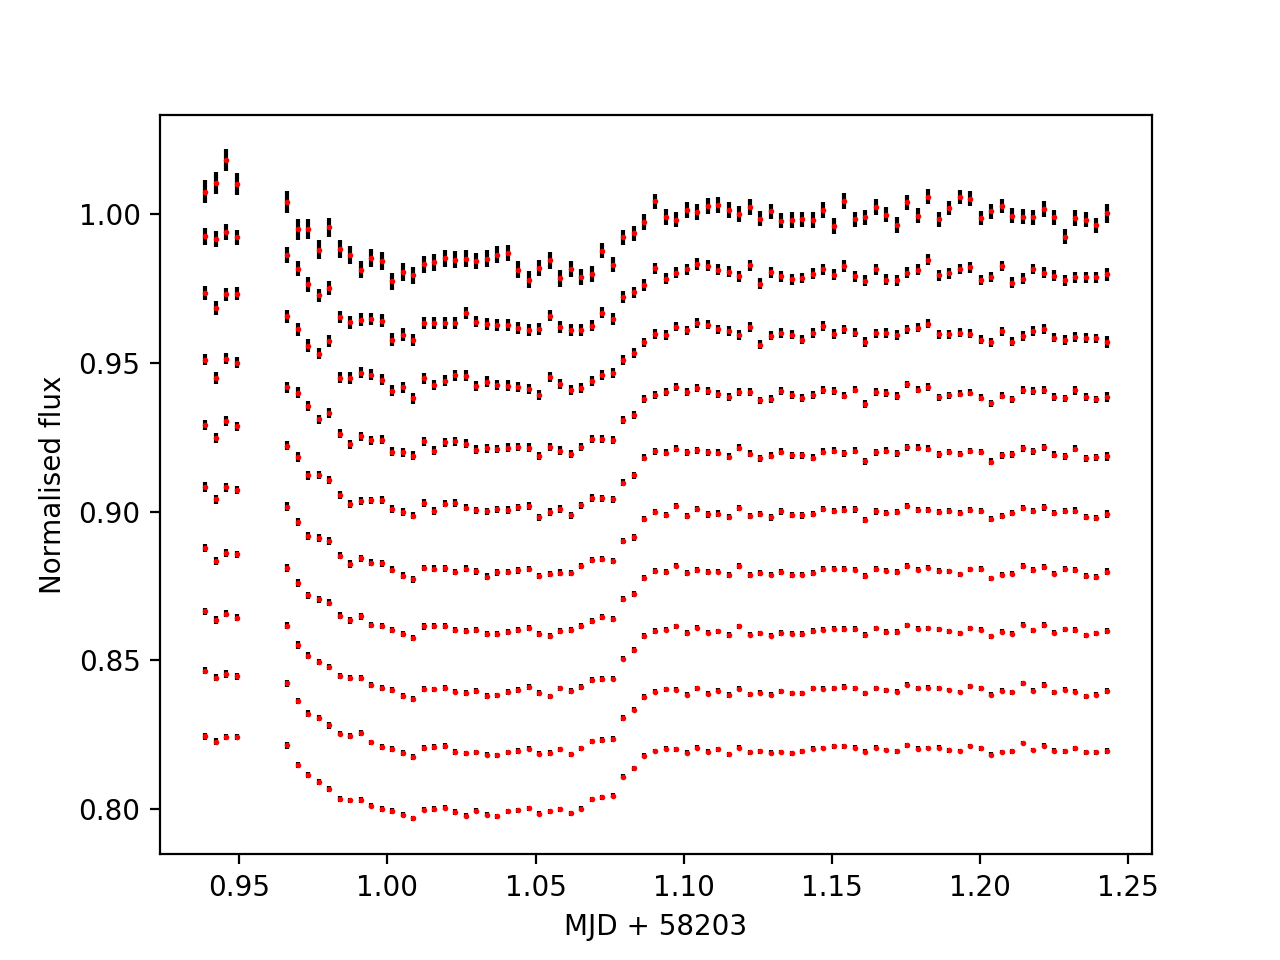

In [28]:

iib_fluxes_K = []
iib_errors_K = []
iib_xpos_K = []
iib_sky_K = []
iib_centres_K = []
iib_widths_K = []

 
for i in bin_widths_iib:
    
    # centering on potassium D1
    
    # left hand boundary is 7645A
    if wb.potassium_d1 - i/2 >= 7645:
        bin_left = wb.potassium_d1 - i/2
        bin_right = wb.potassium_d1 + i/2
        iib_centres_K.append(wb.potassium_d1)
        iib_widths_K.append(i)
    else: # bin expands towards the red
        bin_left = 7645
        bin_right = bin_left + i
        iib_centres_K.append((bin_left+bin_right)//2)
        iib_widths_K.append(i)
    
    curr_flux,curr_error,_,_,_,_,curr_xpos,curr_sky,_,_ = \
    wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,np.array([bin_left,bin_right]),\
                    n_tukey_points=0,xpos=xpos,sky=sky,weighted=False)

    iib_fluxes_K.append(curr_flux[0])
    iib_errors_K.append(curr_error[0])
    iib_xpos_K.append(curr_xpos[0])
    iib_sky_K.append(curr_sky[0])
    
iib_fluxes_K = np.array(iib_fluxes_K)
iib_errors_K = np.array(iib_errors_K)
iib_centres_K = np.array(iib_centres_K)
iib_widths_K = np.array(iib_widths_K)
iib_xpos_K = np.array(iib_xpos_K)
iib_sky_K = np.array(iib_sky_K)
    
nf_K_iib, ne_K_iib = wb.normalise_flux(iib_fluxes_K,iib_errors_K,contact1,contact4)

wb.plot_all_bins(mjd,nf_K_iib, ne_K_iib)

And save:

In [29]:
# pickle.dump(nf_K_iib,open('../pickled_objects/K/iib/fluxes.pickle','wb'))
# pickle.dump(ne_K_iib,open('../pickled_objects/K/iib/errors.pickle','wb'))

# pickle.dump(iib_centres_K,open('../pickled_objects/K/iib/centres.pickle','wb'))
# pickle.dump(iib_widths_K,open('../pickled_objects/K/iib/widths.pickle','wb'))

# pickle.dump(iib_xpos_K,open('../pickled_objects/K/iib/xpos.pickle','wb'))
# pickle.dump(iib_sky_K,open('../pickled_objects/K/iib/sky.pickle','wb'))

Now we can move to notebook 6 - preparing the white light curve for fitting.